In [77]:
from music21 import *
us = environment.UserSettings()
us['musicxmlPath'] = 'C:\\Program Files\\MuseScore 3\\bin\\MuseScore3.exe'
us['musescoreDirectPNGPath'] = 'C:\\Program Files\\MuseScore 3\\bin\\MuseScore3.exe'
us['musicxmlPath']



WindowsPath('C:/Program Files/MuseScore 3/bin/MuseScore3.exe')

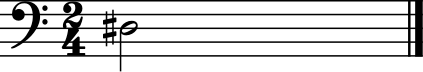

In [78]:
n = note.Note("D#3")
n.duration.type = 'half'
n.show()

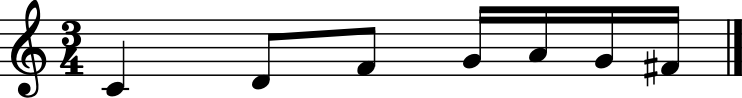

In [79]:
littleMelody = converter.parse("tinynotation: 3/4 c4 d8 f g16 a g f#")
littleMelody.show()


In [80]:

littleMelody.show('midi')

In [81]:
#Leiab kõik taktid ja takti sisu ning paneb need sõnastikku, sõnastikud lähevad listi
def get_measure_info(part, partList):
    measures = [] #List, kuhu lähevad measure dictid:
    chords = []
    rests = []
    notes = []
    allInfo = []
    melNotes = []
    notesDur = 0
    restsDur = 0
    for e in part.getElementsByClass('Measure'):
        newMeasure = {}        
        newMeasure[e.number] = list(e.notesAndRests.elements) #EVERYTHING IN one place
        measureInt =[]
        if e.hasVoices():
            for voice in e.getElementsByClass('Voice'):
                for v in voice.elements:
                    newMeasure[e.number].append(v)
        for elem in newMeasure[e.number]:
            if elem.isNote:
                notes.append(elem.nameWithOctave)
                notesDur+=elem.duration.quarterLength
                allInfo.append(elem)
                measureInt.append(elem)
                melNotes.append(elem)
            elif elem.isChord and '<music21.harmony.ChordSymbol' not in str(elem):
                chords.append(elem.pitchedCommonName)
                notesDur+=elem.duration.quarterLength
                measureInt.append(elem.notes[-1])
                allInfo.append(elem.notes[-1])
                melNotes.append(elem.notes[-1])
                for c in elem.notes:
                    notes.append(c.nameWithOctave)
            elif elem.isRest:
                restsDur+=elem.duration.quarterLength
        newMeasure[e.number].append(measureInt) 
        measures.append(newMeasure)
    rests.append(notesDur)
    rests.append(restsDur)
    partList['melodynotes'] = melNotes
    partList['notes'] = notes
    partList['chords'] = chords
    partList['rests'] = rests
    partList['intervals'] = find_intervals(allInfo)
    
    return measures

In [82]:
#Taandab kõik intervallid 0-12 pooltooni vahemikku
def check_semitones1(st_inter, intervals):
    if 24 > st_inter > 12:
        st_inter = st_inter-12
        intervals.append(st_inter)
    elif 36 > st_inter > 24:
        st_inter = st_inter-24
        intervals.append(st_inter)
    elif 48 > st_inter > 36:
        st_inter = st_inter-36
        intervals.append(st_inter)
    elif -24 < st_inter < -12:
        st_inter = st_inter+12
        intervals.append(st_inter)
    elif -36 < st_inter < -24:
        st_inter = st_inter+24
        intervals.append(st_inter)
    elif -48 < st_inter < -36:
        st_inter = st_inter+36
        intervals.append(st_inter)
    else:
        intervals.append(st_inter)

#Taandab kõik intervallid 0-12 pooltooni vahemikku
def check_semitones(st_inter, intervals):
    if st_inter > 12:
        st_inter = st_inter % 12  
    elif st_inter < -12:
        st_inter = st_inter % -12
    intervals.append(st_inter)
    
        
#Tuvastab nootide vahelised intervallid  
def find_intervals(allInfo):
    intervals= []
    i=1 #Alustan 2. noodist, sest pean alati kontrollima, kas eelmine noot on noot või mitte.
    while i != len(allInfo) and len(allInfo) != 0 and len(allInfo) != 1:
        if allInfo[i-1].isNote and allInfo[i].isNote:
            inter = interval.Interval(noteStart=allInfo[i-1], noteEnd=allInfo[i]).semitones
            check_semitones(inter,intervals)
            
        i+=1
    return intervals

#Saame instrumentide nimed kätte partiidest
def get_instruments(note):
    lst=[]
    for i in range (len(note)):
        if 'partName' in note[i]:
            lst.append(note[i].get('partName'))
    return lst

#Saame tõenäoliseima noodi helistiku
def get_key(note):
    lst=[]
    for i in range (len(note)):
        if 'key' in note[i]:
            lst.append(note[i].get('key'))
    if lst == []:
        return "Ei suutnud helistikku määrata."
    else:
        return str(max(set(lst), key = lst.count))
    
#Saame noodis esinevate taktide arvu
def get_bars_count(note):
    return len(note[1].get('measures'))

#Saame kätte enimkasutatud nootide, intervallide jne info
def get_elements_info(note, name):
    intervalDict = {0:"P0", 1:"v2", 2:"S2",
                    3:"v3", 4:"S3", 5:"P4", 6:"Tritoon",
                    7:"P5", 8:"v6", 9:"S6", 10:"v7",
                    11: "S7", 12:"P8"}
    count= 0
    mostUsed = "Puudub"
    lst = []
    for i in range(0,len(note)):
        elements = note[i].get(name)
        s = len(elements)
        count+=s
        lst+=elements
    
    if lst != []:
        mostUsed = max(set(lst), key=lst.count)
    if name=="intervals":
        mostUsed = intervalDict.get(mostUsed)
    
    return (count, mostUsed)

#Saame teada noodis olevate pauside protsentuaalse koguse
def get_rests_info(note, name):
    notesDur =0
    restsDur =0
    wholeDur =0
    for elem in note:
        if name in elem:
            elements = elem.get(name)
            notesDur+=elements[0]
            restsDur+=elements[1]
    wholeDur+= notesDur + restsDur
    percent = (restsDur*100)/wholeDur
    return str(round(percent,1))

#Saame kätte noodi tempo
def get_tempo(note):
    return note[1].get('bpm')

In [83]:
# Analyze gives: 
# list[0] - sheet name
# list [1] - info of the sheet and partList 1 (esimene rida)- CHECK the ALGORITHM
# list [2] - info of the sheet and partList 2 (teine rida) - ainult meloodia noot, kui chordi ära ei arva.
# list [3] - kõik noodid üldse kokku
# list [4] - kõik intervallid üldse kokku

## Sheet music analyzer

* melodynotes -> 
* notes ->
* chords ->
* rests ->
* intervals -> 


Offset näitab mitmenda täislöögi indeksist takt algab (index 0, 1, 2....) Kui offset on 3, siis takt algab kogu noodistuse mõistes 3. löögist

In [84]:
#Leiab kõik taktid ja takti sisu ning paneb need sõnastikku, sõnastikud lähevad listi
def get_measure_info(part, partList):
    measures = [] #List, kuhu lähevad measure dictid:
    chords = []
    rests = []
    notes = []
    allInfo = []
    melNotes = []
    notesDur = 0
    restsDur = 0
    for e in part.getElementsByClass('Measure'):
        newMeasure = {}        
        newMeasure[e.number] = list(e.notesAndRests.elements)
        print(newMeasure)
        measureInt =[]
        if e.hasVoices():
            for voice in e.getElementsByClass('Voice'):
                for v in voice.elements:
                    newMeasure[e.number].append(v)
        for elem in newMeasure[e.number]:
            if elem.isNote:
                notes.append(elem.nameWithOctave)
                notesDur+=elem.duration.quarterLength
                allInfo.append(elem)
                measureInt.append(elem)
                melNotes.append(elem)
            elif elem.isChord and '<music21.harmony.ChordSymbol' not in str(elem):
                chords.append(elem.pitchedCommonName)
                notesDur+=elem.duration.quarterLength
                
                #Takes the first note of the chords
                measureInt.append(elem.notes[-1])
                allInfo.append(elem.notes[-1])
                melNotes.append(elem.notes[-1])
                for c in elem.notes:
                    notes.append(c.nameWithOctave)
            elif elem.isRest:
                restsDur+=elem.duration.quarterLength
        newMeasure[e.number].append(measureInt) 
        measures.append(newMeasure)
    rests.append(notesDur)
    rests.append(restsDur)
    partList['melodynotes'] = melNotes
    partList['notes'] = notes
    partList['chords'] = chords
    partList['rests'] = rests
    partList['intervals'] = find_intervals(allInfo)
    
    return measures

In [85]:
def get_measure_and_notes(part):
    measures = []
    detailed_seq = [] #Whole note part sequence without meassure markings
    for e in part.getElementsByClass('Measure'):
        newMeasure = {}        
        newMeasure[e.number] = list(e.notesAndRests.elements)
        
        for elem in newMeasure[e.number]:
            if elem.isNote:
                detailed_seq.append((e.number, elem.pitch.name, elem.pitch.octave, elem.duration.quarterLength))
                #detailed_seq.append(str(elem.nameWithOctave) + '_'+ str(elem.duration.quarterLength))
                #print(elem.offset)
            elif elem.isChord and '<music21.harmony.ChordSymbol' not in str(elem):
                notes = []
                for c in elem.notes:
                    notes.append((e.number, c.pitch.name, c.pitch.octave, c.duration.quarterLength))
                detailed_seq.append(notes)
            elif elem.isRest:
                detailed_seq.append((e.number, str(elem.name) + '_'+ str(elem.duration.quarterLength)))
        
        measures.append(newMeasure)
    #print(detailed_seq)
    return detailed_seq


* Kuidas märkida muutuva taktimõõdu või muutuva tempo korral? Kõik taktimõõdud üle partii märgitakse üles.

* Kuidas märkida parima tulemusega helistik? - Helistikke leitakse kahe algoritmiga, Krumhansl ja AardenEssen - kui tulemused on erinevad, siis pannakse mõlemad tabelisse sisse, kontroll sharpside osas ja teha n-ö 1. valik ja 2. valik

* Tempo määramine - sõnastiku järgi kui on sõna, numbri järgi kui on number Checki mitmeid numbereid sõna vastu (sõnastik tempode märkidest

In [86]:
def gather_part_info(note, noteName, note_id):
    allNote = [] #Every part of the instrument is collected here
    for el in note.elements: #Iga part eraldi el = PartStaff
        
        #Basic info
        partList = {}
        partList['note_id'] = note_id
        partList['sheet_name'] = noteName
        partList['partName'] = el.partName 
        partList['sharps'] = el[1].keySignature.sharps #1. taktist saab helistiku märgid kätte.
        partList['bpm'] = "None"
        
        #Find the key
        try:
            if el.analyze('Krumhansl') == el.analyze('AardenEssen'):
                partList['key'] = el.analyze('Krumhansl').name  #MusicXML enda tuvastusalgoritm (ei ole alati täpne)
            else:
                partList['key'] = str(el.analyze('Krumhansl').name) + "  /  " +  str(el.analyze('AardenEssen')) #TODO: Check against dictionary
        except:
            partList['key'] = "None"
            
        #Find time signature
        time_signatures = []
        for i in (el['TimeSignature']):
            time_signatures.append(str(i.numerator) + '/' + str(i.denominator))
        if len(set(time_signatures)) == 0:
            partList['time_signature'] = "None"
        elif len(set(time_signatures)) == 1:
            partList['time_signature'] = time_signatures[0]
        else:
            partList['time_signature'] = set(time_signatures)
        
        #Find the Metronome
        metronome = []
        for i in el['MetronomeMark']: #TODO: Check against dictionary
            metronome.append(str(i.number))
        if len(set(metronome)) == 0:
            partList['bpm (quarter note)'] = "None" #MuseScore gives a default of 120.
        elif len(set(metronome)) == 1:
            partList['bpm (quarter note)'] = metronome[0]
        else:
            partList['bpm (quarter note)'] = set(metronome)
            
        #Find the clef
        partList['clef'] = el[1].clef.name
        partList['measures'] = get_measure_and_notes(el)
        #print(partList['measures'])
        allNote.append(partList)
    return allNote

In [87]:
c = converter.parse(r'C:\Users\Lleis\Documents\SCHOOL\digimagister\digital_sheet_music_analysis\musicxml notes\bond.musicxml')
c1 = converter.parse(r'C:\Users\Lleis\Documents\SCHOOL\digimagister\digital_sheet_music_analysis\musicxml notes\chopin.musicxml')
#c2 = converter.parse(r'C:\Users\Lleis\Documents\SCHOOL\digimagister\digital_sheet_music_analysis\musicxml notes\fur_elise.musicxml')
partStream = c.parts.stream()
note_info= gather_part_info(partStream, 'chopin', 2)
print(note_info)

[{'note_id': 2, 'sheet_name': 'chopin', 'partName': 'Piano', 'sharps': 1, 'bpm': 'None', 'key': 'E minor', 'time_signature': '4/4', 'bpm (quarter note)': '72.0', 'clef': 'treble', 'measures': [(1, 'E', 4, 0.5), (1, 'B', 3, 0.5), (1, 'F#', 4, 0.5), (1, 'B', 3, 0.5), (1, 'G', 4, 0.5), (1, 'B', 3, 0.5), (1, 'B', 4, 0.5), (1, 'B', 3, 0.5), (2, 'E', 4, 0.5), (2, 'C', 4, 0.5), (2, 'F#', 4, 0.5), (2, 'C', 4, 0.5), (2, 'G', 4, 0.5), (2, 'C', 4, 0.5), (2, 'B', 4, 0.5), (2, 'C', 4, 0.5), (3, 'E', 4, 0.5), (3, 'C#', 4, 0.5), (3, 'F#', 4, 0.5), (3, 'C#', 4, 0.5), (3, 'G', 4, 0.5), (3, 'C#', 4, 0.5), (3, 'B', 4, 0.5), (3, 'C#', 4, 0.5), (4, 'D#', 4, 0.5), (4, 'B', 3, 0.5), (4, 'E', 4, 0.5), (4, 'B', 3, 0.5), (4, 'F#', 4, 2.0), [(5, 'E', 4, 1.0), (5, 'E', 5, 1.0)], [(5, 'F#', 4, 1.0), (5, 'F#', 5, 1.0)], [(5, 'G', 4, 1.0), (5, 'G', 5, 1.0)], [(5, 'B', 4, 1.0), (5, 'B', 5, 1.0)], [(6, 'E', 4, 1.0), (6, 'E', 5, 1.0)], [(6, 'F#', 4, 1.0), (6, 'F#', 5, 1.0)], [(6, 'G', 4, 1.0), (6, 'G', 5, 1.0)], [(6, '

Sheets may have textboxes before the partstaffs.

* sheet[0][0] - metadata

* sheet[1] -> 1.partStaff
* sheet[1][1] -> 1. partStaff 1. measure
* sheet[1][1][1] -> 1. partStaff 1. measure 'SystemLayout' 
* sheet[1][1][1] -> 1. partStaff 1. measure 'Trebleclef' 
* sheet[1][1][2] -> 1. partStaff 1. measure 'Keysignature'
* sheet[1][1][3] -> 1. partStaff 1. measure 'Timesignature'
* sheet[1][1][4] -> 1. partStaff 1. measure First Note / Chord
    - If chord then
      *   sheet[1][1][4][0] -> 1. partStaff 1. measure First Note, lower note
      *   sheet[1][1][4][1] -> 1. partStaff 1. measure First Note, upper note

* len(c.flatten().getElementsByClass(chord.Chord)) - get all the chord elements of entire sheet
* len(c.flatten().getElementsByClass(note.Note)) - get all the note elements of entire sheet (no chord notes)

## Playback function

In [14]:
#print(note_info[0]['measures'])

len(note_info[0]['measures'])
matched_seq = note_info[0]['measures'][0:8]
print(matched_seq)



def get_playback_info(note_info, matched_seq):
    playback = {}
    key = note_info[0]['key'][0]
    time= note_info[0]['time_signature']
    
    notes = ''
    for elem in matched_seq:
        note = elem[0]
        octave =elem[1]
        duration = elem[2]
    
        if octave == 4:
            note = note.lower()
        if duration == 0.5:
            duration = 8
    
        notes = notes + str(note) + str(duration) + ' '
    tinynote = str(time) + ' ' + 'k'+(str(key.lower()) + ' ' + notes)
    return tinynote



tiny = get_playback_info(note_info, matched_seq)

class KeyToken(tinyNotation.Token):
    def parse(self, parent):
        keyName = self.token
        return key.Key(keyName)
tnc = tinyNotation.Converter()
print(tnc)
keyMapping = (r'k(.*)', KeyToken)
tnc.tokenMap.append(keyMapping)
tnc.load(tiny)

tnc.parse()
s = tnc.stream
s.append(tempo.MetronomeMark(150))
s.show()
s.show('midi')





[[('G', 4, 1.0), ('A', 4, 1.0)], [('C#', 4, 1.0), ('A', 4, 1.0)], ('D', 4, 0.5), [('E', 4, 0.5), ('F#', 4, 0.5)], ('A', 3, 0.5), 'rest_0.5', 'rest_4.0']


IndexError: list index out of range

In [245]:
s.show('midi') #default playback tempo is 120, always TODO: How to change?

In [123]:
c3 = converter.parse(r'C:\Users\Lleis\Documents\SCHOOL\digimagister\digital_sheet_music_analysis\musicxml notes\bond3.musicxml')

partStream2 = c3.parts.stream()
note_info2= gather_part_info(partStream2, 'bond', 2)
print(note_info2)

[{'note_id': 2, 'sheet_name': 'bond', 'partName': 'Piano', 'sharps': 2, 'bpm': 'None', 'key': 'B minor', 'time_signature': '4/4', 'bpm (quarter note)': '72.0', 'clef': 'treble', 'measures': [(1, 'B', 3, 0.5), (1, 'F#', 4, 0.5), (1, 'C#', 4, 0.5), (1, 'F#', 3, 0.5), (1, 'D', 4, 0.5), (1, 'F#', 4, 0.5), (1, 'F#', 4, 0.5), (1, 'F#', 3, 0.5), (2, 'B', 3, 0.5), (2, 'G', 3, 0.5), (2, 'C#', 4, 0.5), (2, 'G', 3, 0.5), (2, 'D', 4, 0.5), (2, 'G', 3, 0.5), (2, 'F#', 4, 0.5), (2, 'G', 3, 0.5), (3, 'B', 3, 0.5), (3, 'G#', 3, 0.5), (3, 'C#', 4, 0.5), (3, 'G#', 3, 0.5), (3, 'D', 4, 0.5), (3, 'G#', 3, 0.5), (3, 'F#', 4, 0.5), (3, 'G#', 3, 0.5), (4, 'A#', 3, 0.5), (4, 'F#', 3, 0.5), (4, 'B', 3, 0.5), (4, 'F#', 3, 0.5), (4, 'C#', 4, 2.0), [(5, 'B', 3, 1.0), (5, 'B', 4, 1.0)], [(5, 'C#', 4, 1.0), (5, 'C#', 5, 1.0)], [(5, 'D', 4, 1.0), (5, 'D', 5, 1.0)], [(5, 'F#', 4, 1.0), (5, 'F#', 5, 1.0)], [(6, 'B', 3, 1.0), (6, 'B', 4, 1.0)], [(6, 'C#', 4, 1.0), (6, 'C#', 5, 1.0)], [(6, 'D', 4, 1.0), (6, 'D', 5, 1.0)

In [124]:

k = c3.analyze('key')
print(k)
i = interval.Interval(k.tonic, pitch.Pitch('a'))
sNew = c3.transpose(i)
sNew
kNew = sNew.analyze('key')

print(kNew)

partStream2 = sNew.parts.stream()
note_info2= gather_part_info(partStream2, 'bond', 2)
print(note_info2)

b minor
a minor
[{'note_id': 2, 'sheet_name': 'bond', 'partName': 'Piano', 'sharps': 0, 'bpm': 'None', 'key': 'A minor', 'time_signature': '4/4', 'bpm (quarter note)': '72.0', 'clef': 'treble', 'measures': [(1, 'A', 3, 0.5), (1, 'E', 4, 0.5), (1, 'B', 3, 0.5), (1, 'E', 3, 0.5), (1, 'C', 4, 0.5), (1, 'E', 4, 0.5), (1, 'E', 4, 0.5), (1, 'E', 3, 0.5), (2, 'A', 3, 0.5), (2, 'F', 3, 0.5), (2, 'B', 3, 0.5), (2, 'F', 3, 0.5), (2, 'C', 4, 0.5), (2, 'F', 3, 0.5), (2, 'E', 4, 0.5), (2, 'F', 3, 0.5), (3, 'A', 3, 0.5), (3, 'F#', 3, 0.5), (3, 'B', 3, 0.5), (3, 'F#', 3, 0.5), (3, 'C', 4, 0.5), (3, 'F#', 3, 0.5), (3, 'E', 4, 0.5), (3, 'F#', 3, 0.5), (4, 'G#', 3, 0.5), (4, 'E', 3, 0.5), (4, 'A', 3, 0.5), (4, 'E', 3, 0.5), (4, 'B', 3, 2.0), [(5, 'A', 3, 1.0), (5, 'A', 4, 1.0)], [(5, 'B', 3, 1.0), (5, 'B', 4, 1.0)], [(5, 'C', 4, 1.0), (5, 'C', 5, 1.0)], [(5, 'E', 4, 1.0), (5, 'E', 5, 1.0)], [(6, 'A', 3, 1.0), (6, 'A', 4, 1.0)], [(6, 'B', 3, 1.0), (6, 'B', 4, 1.0)], [(6, 'C', 4, 1.0), (6, 'C', 5, 1.0)], 

In [43]:
sNew.show('midi')

### Building the dataframe for sheet note information

In [88]:
# Import pandas library
import pandas as pd
 

df = pd.DataFrame(note_info)
df


,note_id,sheet_name,partName,sharps,bpm,key,time_signature,bpm (quarter note),clef,measures
0,2,chopin,Piano,1,None,E minor,4/4,72.0,treble,"[(1, E, 4, 0.5), (1, B, 3, 0.5), (1, F#, 4, 0...."
1,2,chopin,Piano,1,None,E minor,4/4,72.0,bass,"[[(1, E, 2, 3.0), (1, E, 3, 3.0)], (1, B, 5, 1..."


In [163]:
# Create the pandas DataFrame
df2 = pd.DataFrame(note_info2)
df = df.append(df2, ignore_index = True)
df

,note_id,sheet_name,partName,sharps,bpm,key,time_signature,bpm (quarter note),clef,measures
0,2,chopin,Piano,1,None,E minor,4/4,72.0,treble,"[(1, E, 4, 0.5), (1, B, 3, 0.5), (1, F#, 4, 0...."
1,2,chopin,Piano,1,None,E minor,4/4,72.0,bass,"[[(1, E, 2, 3.0), (1, E, 3, 3.0)], (1, B, 5, 1..."
2,2,bond,Piano,0,None,A minor,4/4,72.0,treble,"[(1, A, 3, 0.5), (1, E, 3, 0.5), (1, B, 3, 0.5..."
3,2,bond,Piano,0,None,A minor,4/4,72.0,bass,"[[(1, A, 1, 3.0), (1, A, 2, 3.0)], (1, E, 5, 1..."
4,2,bond,Piano,0,None,A minor,4/4,72.0,treble,"[(1, A, 3, 0.5), (1, E, 3, 0.5), (1, B, 3, 0.5..."
5,2,bond,Piano,0,None,A minor,4/4,72.0,bass,"[[(1, A, 1, 3.0), (1, A, 2, 3.0)], (1, E, 5, 1..."
6,2,bond,Piano,0,None,A minor,4/4,72.0,treble,"[(1, A, 3, 0.5), (1, E, 4, 0.5), (1, B, 3, 0.5..."
7,2,bond,Piano,0,None,A minor,4/4,72.0,bass,"[[(1, A, 1, 3.0), (1, A, 2, 3.0)], (1, E, 5, 1..."
8,2,bond,Piano,0,None,A minor,4/4,72.0,treble,"[(1, A, 3, 0.5), (1, E, 4, 0.5), (1, B, 3, 0.5..."
9,2,bond,Piano,0,None,A minor,4/4,72.0,bass,"[[(1, A, 1, 3.0), (1, A, 2, 3.0)], (1, E, 5, 1..."


In [236]:
lst = []


def construct_strings(n, if_rest, if_chords, m, o):
    lst = []
   
    for i in n:
        if if_rest == False:
            if 'rest' in i[1]:
                continue #skipping rests
        if isinstance(i, list):
            if if_chords == False: #Takes the first note of the chord into account
                elem = i[0][m:o]
                s = ' '.join(map(str,elem))
                lst.append(s)
            else: #Takes the whole chord into account
                cover_lst = []
                for elem in i:

                    elem = elem[m:3]
                    cover_lst.append(elem)
                s = ' '.join(map(str,cover_lst))
                lst.append(s)
        else:
            if 'rest' in i[1]:
                i = i[m:2]
                s = ' '.join(map(str,i))
                lst.append(s)
            else:
                i = i[m:o]
                s = ' '.join(map(str,i))
                lst.append(s)
    return lst

# 0 - if measure nr is taken into account
# 1- if measure nr is NOT taken into account
# 2 - if octave nr is NOT taken into account
# 3 - if octave nr is taken into account

a = construct_strings(df['measures'][6], False, False, 1, 2) 
b = construct_strings(df['measures'][7], False, False, 1, 2)

print(a)

['A', 'E', 'B', 'E', 'C', 'E', 'E', 'E', 'A', 'F', 'B', 'F', 'C', 'F', 'E', 'F', 'A', 'F#', 'B', 'F#', 'C', 'F#', 'E', 'F#', 'G#', 'E', 'A', 'E', 'B', 'A', 'B', 'C', 'E', 'A', 'B', 'C', 'E', 'A', 'B', 'C', 'E', 'F', 'E', 'A', 'G', 'G', 'F', 'E', 'E', 'F', 'A', 'C', 'B', 'B', 'A', 'B', 'B', 'C', 'A', 'A', 'E', 'D', 'C', 'B', 'B', 'A', 'G', 'G', 'F', 'E', 'E', 'F#', 'F', 'E', 'E', 'F', 'E', 'E', 'F', 'E', 'E', 'F', 'E', 'E', 'C', 'C', 'C', 'B', 'B', 'A', 'G', 'G', 'F', 'E', 'E', 'F', 'A', 'B', 'C', 'B', 'G', 'A', 'B', 'B', 'C', 'A', 'A', 'E', 'D', 'C', 'B', 'B', 'A', 'G', 'G', 'F', 'E', 'E', 'D', 'D', 'D', 'E', 'E', 'F', 'E', 'C', 'A', 'F', 'E', 'C', 'A', 'F', 'E', 'C', 'A', 'F', 'E', 'C', 'A', 'C', 'B', 'B', 'B', 'C', 'D', 'C', 'C', 'B', 'C', 'C', 'A', 'B', 'C', 'D', 'C', 'C', 'B', 'C', 'C', 'B', 'C', 'D', 'C', 'C', 'D', 'E', 'F', 'E', 'E', 'F', 'E', 'E', 'G#', 'B', 'E', 'C', 'B', 'E', 'A', 'A', 'F', 'E', 'E', 'D', 'E', 'C', 'B', 'A', 'C', 'C', 'D', 'D', 'D', 'C', 'A', 'E', 'F', 'E', 'E

## N-GRAM

In [237]:
def generate_ngrams(s, n):
    # Convert to lowercases

    
    # Use the zip function to help us generate n-grams
    # Concatentate the tokens into ngrams and return
    ngrams = zip(*[s[i:] for i in range(n)])
    return [ngram for ngram in ngrams]

In [238]:
a = generate_ngrams(a,7)
b = generate_ngrams(b,7)
print(a)
print(b)

[('A', 'E', 'B', 'E', 'C', 'E', 'E'), ('E', 'B', 'E', 'C', 'E', 'E', 'E'), ('B', 'E', 'C', 'E', 'E', 'E', 'A'), ('E', 'C', 'E', 'E', 'E', 'A', 'F'), ('C', 'E', 'E', 'E', 'A', 'F', 'B'), ('E', 'E', 'E', 'A', 'F', 'B', 'F'), ('E', 'E', 'A', 'F', 'B', 'F', 'C'), ('E', 'A', 'F', 'B', 'F', 'C', 'F'), ('A', 'F', 'B', 'F', 'C', 'F', 'E'), ('F', 'B', 'F', 'C', 'F', 'E', 'F'), ('B', 'F', 'C', 'F', 'E', 'F', 'A'), ('F', 'C', 'F', 'E', 'F', 'A', 'F#'), ('C', 'F', 'E', 'F', 'A', 'F#', 'B'), ('F', 'E', 'F', 'A', 'F#', 'B', 'F#'), ('E', 'F', 'A', 'F#', 'B', 'F#', 'C'), ('F', 'A', 'F#', 'B', 'F#', 'C', 'F#'), ('A', 'F#', 'B', 'F#', 'C', 'F#', 'E'), ('F#', 'B', 'F#', 'C', 'F#', 'E', 'F#'), ('B', 'F#', 'C', 'F#', 'E', 'F#', 'G#'), ('F#', 'C', 'F#', 'E', 'F#', 'G#', 'E'), ('C', 'F#', 'E', 'F#', 'G#', 'E', 'A'), ('F#', 'E', 'F#', 'G#', 'E', 'A', 'E'), ('E', 'F#', 'G#', 'E', 'A', 'E', 'B'), ('F#', 'G#', 'E', 'A', 'E', 'B', 'A'), ('G#', 'E', 'A', 'E', 'B', 'A', 'B'), ('E', 'A', 'E', 'B', 'A', 'B', 'C'), ('

In [192]:
def jaccard_distance(a, b):
    """Calculate the jaccard distance between sets A and B"""
    intersection = len(list(set(a).intersection(b)))
    union = (len(set(a)) + len(set(b))) - intersection
    return float(intersection) / union

def cosine_similarity_ngrams(a, b):
    vec1 = Counter(a)
    vec2 = Counter(b)
    
    intersection = set(vec1.keys()) & set(vec2.keys())
    numerator = sum([vec1[x] * vec2[x] for x in intersection])

    sum1 = sum([vec1[x]**2 for x in vec1.keys()])
    sum2 = sum([vec2[x]**2 for x in vec2.keys()])
    denominator = math.sqrt(sum1) * math.sqrt(sum2)

    if not denominator:
        return 0.0
    return float(numerator) / denominator

In [193]:
print("Jaccard: {}   Cosine: {}".format(jaccard_distance(a,b), cosine_similarity_ngrams(a,b)))

Jaccard: 0.0   Cosine: 0.0


In [230]:
# Get Tuple algorithms 
import re
import math
import numpy as np
from itertools import chain
from collections import Counter
import nltk
from nltk.util import ngrams # This is the ngram magic.

print("Jaccard: {}   Cosine: {}".format(jaccard_distance(a,b), cosine_similarity_ngrams(a,b)))


Jaccard: 0.011848341232227487   Cosine: 0.01688572187982372


In [215]:
# Python3 implementation of above approach
from math import floor, ceil
 
# Function to calculate the
# Jaro Similarity of two s
def jaro_distance(s1, s2):
     
    # If the s are equal
    if (s1 == s2):
        return 1.0
 
    # Length of two s
    len1 = len(s1)
    len2 = len(s2)
 
    # Maximum distance upto which matching
    # is allowed
    max_dist = floor(max(len1, len2) / 2) - 1
 
    # Count of matches
    match = 0
 
    # Hash for matches
    hash_s1 = [0] * len(s1)
    hash_s2 = [0] * len(s2)
 
    # Traverse through the first
    for i in range(len1):
 
        # Check if there is any matches
        for j in range(max(0, i - max_dist),
                       min(len2, i + max_dist + 1)):
             
            # If there is a match
            if (s1[i] == s2[j] and hash_s2[j] == 0):
                hash_s1[i] = 1
                hash_s2[j] = 1
                match += 1
                break
 
    # If there is no match
    if (match == 0):
        return 0.0
 
    # Number of transpositions
    t = 0
    point = 0
 
    # Count number of occurrences
    # where two characters match but
    # there is a third matched character
    # in between the indices
    for i in range(len1):
        if (hash_s1[i]):
 
            # Find the next matched character
            # in second
            while (hash_s2[point] == 0):
                point += 1
 
            if (s1[i] != s2[point]):
                t += 1
            point += 1
    t = t//2
 
    # Return the Jaro Similarity
    return (match/ len1 + match / len2 +
            (match - t) / match)/ 3.0
 

 
# Prjaro Similarity of two s
print(round(jaro_distance(a, b),6))
 
# This code is contributed by mohit kumar 29

0.337248


In [239]:
from difflib import SequenceMatcher
def match_seq(list1,list2):
    output=[]
    s = SequenceMatcher(None, list1, list2)
    blocks=s.get_matching_blocks()
    for bl in blocks:
        for bi in range(bl.size):
            cur_a=bl.a+bi
            cur_b=bl.b+bi
            output.append((cur_a,cur_b))
    return output
for x,y in match_seq(a,b):
    print(x,y, a[x],b[y])


233 80 ('E', 'A', 'E', 'C', 'E', 'A', 'E') ('E', 'A', 'E', 'C', 'E', 'A', 'E')
455 112 ('E', 'A', 'E', 'C', 'E', 'A', 'E') ('E', 'A', 'E', 'C', 'E', 'A', 'E')
491 597 ('E', 'A', 'E', 'C', 'E', 'A', 'E') ('E', 'A', 'E', 'C', 'E', 'A', 'E')


In [217]:
print(a)

[('A 3', 'E 4', 'B 3', 'E 3'), ('E 4', 'B 3', 'E 3', 'C 4'), ('B 3', 'E 3', 'C 4', 'E 4'), ('E 3', 'C 4', 'E 4', 'E 4'), ('C 4', 'E 4', 'E 4', 'E 3'), ('E 4', 'E 4', 'E 3', 'A 3'), ('E 4', 'E 3', 'A 3', 'F 3'), ('E 3', 'A 3', 'F 3', 'B 3'), ('A 3', 'F 3', 'B 3', 'F 3'), ('F 3', 'B 3', 'F 3', 'C 4'), ('B 3', 'F 3', 'C 4', 'F 3'), ('F 3', 'C 4', 'F 3', 'E 4'), ('C 4', 'F 3', 'E 4', 'F 3'), ('F 3', 'E 4', 'F 3', 'A 3'), ('E 4', 'F 3', 'A 3', 'F# 3'), ('F 3', 'A 3', 'F# 3', 'B 3'), ('A 3', 'F# 3', 'B 3', 'F# 3'), ('F# 3', 'B 3', 'F# 3', 'C 4'), ('B 3', 'F# 3', 'C 4', 'F# 3'), ('F# 3', 'C 4', 'F# 3', 'E 4'), ('C 4', 'F# 3', 'E 4', 'F# 3'), ('F# 3', 'E 4', 'F# 3', 'G# 3'), ('E 4', 'F# 3', 'G# 3', 'E 3'), ('F# 3', 'G# 3', 'E 3', 'A 3'), ('G# 3', 'E 3', 'A 3', 'E 3'), ('E 3', 'A 3', 'E 3', 'B 3'), ('A 3', 'E 3', 'B 3', 'A 3'), ('E 3', 'B 3', 'A 3', 'B 3'), ('B 3', 'A 3', 'B 3', 'C 4'), ('A 3', 'B 3', 'C 4', 'E 4'), ('B 3', 'C 4', 'E 4', 'A 3'), ('C 4', 'E 4', 'A 3', 'B 3'), ('E 4', 'A 3', 'B 3

In [245]:
print(df['measures'][4][233:233+7])

[(35, 'rest_0.5'), [(35, 'G', 3, 0.25), (35, 'G', 4, 0.25)], [(35, 'A', 3, 0.25), (35, 'A', 4, 0.25)], [(36, 'A', 3, 1.0), (36, 'A', 4, 1.0)], (36, 'rest_0.5'), [(36, 'C', 4, 0.5), (36, 'C', 5, 0.5)], [(36, 'B', 3, 0.5), (36, 'F', 4, 0.5), (36, 'A', 4, 0.5), (36, 'B', 4, 0.5)]]


In [243]:
print(df['measures'][5][80:80+7])

[(19, 'E', 3, 0.25), (19, 'A', 3, 0.25), (19, 'E', 3, 0.25), (19, 'C', 4, 0.25), (19, 'E', 3, 0.25), (19, 'A', 3, 0.25), (19, 'E', 3, 0.25)]


# Generating harmony to melody (not worth a try)

In [300]:
test_lst = df['measures'][4][0:300] #First 4 measures

In [301]:
harmony_chords = {
    1: ['A', 'C', 'E'],
    2: ['B', 'D', 'F#'],
    3: ['C', 'E', 'G#'],
    4: ['D', 'F#', 'A'],
    5: ['E', 'G#', 'B'],
    6: ['F', 'A', 'C'],
    7: ['G', 'B', 'D']
}

measure= []
for i in test_lst:
    if i[0] == 9:
        measure.append(i[1:2][0])


print(measure)
print(harmony_chords[2])



for elem in harmony_chords:
    print(str(elem) + ': ' + str(jaccard_distance(measure,harmony_chords[elem])) + ', ' + str(cosine_similarity_ngrams(measure,harmony_chords[elem])))

    
    
'''
1 = 1 kindel
2 = 6 kindel
3 = 4
4 = 5
'''

['rest_1.0', 'A', 'G', 'G', 'F', 'E']
['B', 'D', 'F#']
1: 0.3333333333333333, 0.40824829046386296
2: 0.0, 0.0
3: 0.14285714285714285, 0.20412414523193148
4: 0.14285714285714285, 0.20412414523193148
5: 0.14285714285714285, 0.20412414523193148
6: 0.3333333333333333, 0.40824829046386296
7: 0.14285714285714285, 0.40824829046386296


'\n1 = 1 kindel\n2 = 6 kindel\n3 = 4\n4 = 5\n'

# Bach's corpus (last index is 412)
### .krn file is HUMDRUM tool KERN file

In [334]:
from music21 import corpus
from pathlib import Path  

paths = corpus.getComposer('bach')

del df


c3 = converter.parse(r'C:\Users\Lleis\Documents\SCHOOL\digimagister\digital_sheet_music_analysis\musicxml notes\bond3.musicxml')
partStream2 = c3.parts.stream()
note_info2= gather_part_info(partStream2, 'bond', 2)
df = pd.DataFrame(note_info2)

list_of_music = []

for i in paths:
    list_of_music.append(i.name)

test = list_of_music[0:413]

for note in test:
    if '.mxl' in note:
        s = corpus.parse('bach/' + note)

        partStream2 = s.parts.stream()
        idx = df['note_id'].iloc[-1]

        note_info2= gather_part_info(partStream2, note, idx+1)
        df_new = pd.DataFrame(note_info2)

        df = df.append(df_new, ignore_index = True)


In [335]:
df

,note_id,sheet_name,partName,sharps,bpm,key,time_signature,bpm (quarter note),clef,measures
0,2,bond,Piano,2,None,B minor,4/4,72.0,treble,"[(1, B, 3, 0.5), (1, F#, 4, 0.5), (1, C#, 4, 0..."
1,2,bond,Piano,2,None,B minor,4/4,72.0,bass,"[[(1, B, 1, 3.0), (1, B, 2, 3.0)], (1, F#, 5, ..."
2,3,bwv1.6.mxl,Horn 2,-1,None,F major,4/4,None,treble,"[(0, F, 4, 1.0), (1, G, 4, 0.5), (1, C, 4, 0.5..."
3,3,bwv1.6.mxl,Soprano,-1,None,F major,4/4,None,treble,"[(0, F, 4, 1.0), (1, C, 5, 1.0), (1, A, 4, 1.0..."
4,3,bwv1.6.mxl,Alto,-1,None,F major,4/4,None,treble,"[(0, C, 4, 1.0), (1, C, 4, 1.0), (1, C, 4, 1.0..."
...,...,...,...,...,...,...,...,...,...,...
1752,409,bwv97.9.mxl,Bass,-2,None,B- major,4/4,None,bass,"[(0, B-, 2, 1.0), (1, B-, 3, 1.0), (1, A, 3, 1..."
1753,410,bwv99.6.mxl,Soprano,1,None,D major / G major,4/4,None,treble,"[(0, D, 4, 1.0), (1, G, 4, 1.0), (1, A, 4, 1.0..."
1754,410,bwv99.6.mxl,Alto,1,None,G major / D major,4/4,None,treble,"[(0, B, 3, 0.5), (0, C, 4, 0.5), (1, D, 4, 1.0..."
1755,410,bwv99.6.mxl,Tenor,1,None,B minor / G major,4/4,None,bass,"[(0, G, 3, 0.5), (0, A, 3, 0.5), (1, B, 3, 1.0..."


In [338]:
df.to_csv('bach_notes.csv')

In [333]:
s = corpus.parse('bach/bwv277.mxl')
s.show('midi')